In [0]:
from google.colab import drive 
drive.mount("/betogaona7")

In [1]:
%cd ./../betogaona7/My\ Drive/app/MobileNet

/betogaona7/My Drive/app/MobileNet


In [0]:
import os 
import random
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchvision import models, datasets, transforms, utils
from torch.utils.data import Dataset

## Helper functions

In [0]:
def unnormalize(img):
  img = (img/2)+0.5 
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None

def decode_label(label):
  actions = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
  return actions[label]

## Dataset

(150, 150)


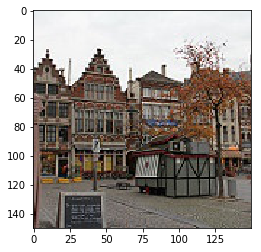

In [4]:
img = Image.open("./data/seg_train/buildings/10480.jpg")
print(img.size)
plt.imshow(img)

In [0]:
traindir = './data/seg_train/'
validdir = './data/seg_test/'
train_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                       transforms.RandomHorizontalFlip(0.4),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

valid_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(traindir, transform=train_transforms)
valid_data = datasets.ImageFolder(validdir, transform=valid_transforms)


trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, num_workers=8, batch_size=128)
validloader = torch.utils.data.DataLoader(valid_data, shuffle=False, num_workers=8, batch_size=128)

In [36]:
print("Classes: ", trainloader.dataset.classes)

Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Visualize training samples

torch.Size([3, 64, 64])


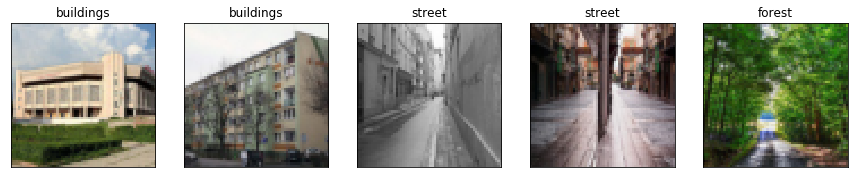

In [37]:
batch = next(iter(trainloader))

imgs = []
actions = []
for i in range(5):
  sample = random.randint(0, 127)
  img =  unnormalize(batch[0][sample])
  action = decode_label(int(batch[1][sample]))
  imgs.append(img)
  actions.append(action)

print(batch[0][0].shape)
plot_imgs(imgs, actions, (15,15))

## Model

In [0]:
class mobileNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    def separableConv2d(in_channels, out_channels, kernel_size):
      
      return nn.Sequential(nn.Conv2d(in_channels,  in_channels, kernel_size, groups=in_channels),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(in_channels),
                      
                           nn.Conv2d(in_channels, out_channels, 1),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(out_channels))
    
    
    self.conv1 = separableConv2d(3, 16, 3) 
    self.conv2 = separableConv2d(16, 32, 3)
    self.conv3 = separableConv2d(32, 64, 3)
    self.conv4 = separableConv2d(64, 128, 3)
    
    self.pool = nn.MaxPool2d(2,2)
    
    self.fc1 = nn.Linear(2*2*128, 1024)
    self.fc2 = nn.Linear(1024, 6)
    
  def forward(self, x):
    
    x = self.pool(self.conv1(x))
    x = self.pool(self.conv2(x))
    x = self.pool(self.conv3(x))
    x = self.pool(self.conv4(x))
    
    x = x.view(x.size()[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    
    return x

## Training

### Full training

In [0]:
def validation(model, validloader, criterion):
  correct = 0
  total = 0
  for minibatch, batch in enumerate(validloader):
    images, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
model = mobileNet()

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
epochs = 20
print_every = 30

In [53]:
best = 100

for epoch in range(epochs):
  for minibatch, batch in enumerate(trainloader):
    images, labels = batch[0].to(device), batch[1].to(device)
    optimizer.zero_grad()
    
    outputs = model.forward(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if minibatch % print_every == 0:
      model.eval()
      with torch.no_grad():
        accuracy = validation(model, validloader, criterion)
        training_loss = loss.item()
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Loss: {:.5f}.. ".format(training_loss),
              "Accuracy: {}.. ".format(accuracy))
        if best > training_loss:
          torch.save(model.state_dict(), "./lessloss.pth")
          best = training_loss
      model.train()
      
torch.save(model.state_dict(), "./fulltrained.pth")

Epoch: 1/20..  Loss: 1.81085..  Accuracy: 16.7.. 
Epoch: 1/20..  Loss: 1.37228..  Accuracy: 17.533333333333335.. 
Epoch: 1/20..  Loss: 1.06933..  Accuracy: 48.666666666666664.. 
Epoch: 1/20..  Loss: 1.10914..  Accuracy: 56.96666666666667.. 
Epoch: 2/20..  Loss: 1.06204..  Accuracy: 58.6.. 
Epoch: 2/20..  Loss: 1.20402..  Accuracy: 60.7.. 
Epoch: 2/20..  Loss: 0.98450..  Accuracy: 62.833333333333336.. 
Epoch: 2/20..  Loss: 1.14481..  Accuracy: 62.4.. 
Epoch: 3/20..  Loss: 1.03393..  Accuracy: 64.66666666666667.. 
Epoch: 3/20..  Loss: 1.09347..  Accuracy: 62.666666666666664.. 
Epoch: 3/20..  Loss: 0.78935..  Accuracy: 65.03333333333333.. 
Epoch: 3/20..  Loss: 0.98022..  Accuracy: 64.8.. 
Epoch: 4/20..  Loss: 0.96055..  Accuracy: 66.2.. 
Epoch: 4/20..  Loss: 0.89030..  Accuracy: 67.66666666666667.. 
Epoch: 4/20..  Loss: 0.92452..  Accuracy: 67.76666666666667.. 
Epoch: 4/20..  Loss: 0.95982..  Accuracy: 68.56666666666666.. 
Epoch: 5/20..  Loss: 0.85728..  Accuracy: 70.66666666666667.. 
Epo

## Evaluation

In [56]:
saved_file = "./lessloss.pth"
saved_file2 = "./fulltrained.pth"

state_dict = torch.load(saved_file)
model.load_state_dict(state_dict)

model.eval()
with torch.no_grad():
  acc = validation(model, validloader, criterion)
  print("Validation accuracy: ", acc)

Validation accuracy:  74.43333333333334


In [58]:
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

with torch.no_grad():
  for minibatch, batch in enumerate(validloader):
    images, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    
    for sample in range(128):
      try:
        label = labels[sample]
        class_correct[label] += c[sample].item()
        class_total[label] += 1
      except:
        break
      
for i in range(6):
  print("Accuracy of %5s : %2d %%" % (decode_label(i), 100*class_correct[i]/class_total[i]))

Accuracy of buildings : 75 %
Accuracy of forest : 91 %
Accuracy of glacier : 58 %
Accuracy of mountain : 75 %
Accuracy of   sea : 73 %
Accuracy of street : 75 %
